In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision import datasets, models
from torch.optim import lr_scheduler
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
#from torchvision.models.segmentation.deeplabv3 import DeepLabHead

In [12]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda'

In [42]:
import os
import datetime
import random
from PIL import Image
import time
import math

In [14]:
from torchvision.utils import make_grid

In [15]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.optim as optim

In [16]:
#import segmentation_models_pytorch as smp

In [17]:
from datasets import load_dataset

In [18]:
ds = load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data")

Found cached dataset nyu_depth_v2 (G:/DepthSegmentation/data/sayakpaul___nyu_depth_v2/default/1.0.0/80157dc55fc37d154eb8157db00139028820c686cd2955a43a1d3850e315c383)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [10:24<00:00, 312.50s/it]


In [19]:
LEARNING_RATE = 1e-4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 8
NUM_EPOCHS = 100
NUM_WORKERS = 2
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
PIN_MEMORY = True
LOAD_MODEL = True


In [20]:
#model = model = smp.Unet('resnet152', encoder_weights='imagenet')
#model = UNET()

In [165]:
def weights_init(m):
    # Initialize kernel weights with Gaussian distributions
    if isinstance(m, nn.Conv2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.ConvTranspose2d):
        n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
        m.weight.data.normal_(0, math.sqrt(2. / n))
        if m.bias is not None:
            m.bias.data.zero_()
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.fill_(1)
        m.bias.data.zero_()
def conv(in_channels, out_channels, kernel_size):
    padding = (kernel_size-1) // 2
    assert 2*padding == kernel_size-1, "parameters incorrect. kernel={}, padding={}".format(kernel_size, padding)
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,kernel_size,stride=1,padding=padding,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )
def pointwise(in_channels, out_channels):
    return nn.Sequential(
          nn.Conv2d(in_channels,out_channels,1,1,0,bias=False),
          nn.BatchNorm2d(out_channels),
          nn.ReLU(inplace=True),
        )
class ResNetSkipAdd(nn.Module):
    def __init__(self, layers, output_size, in_channels=3, pretrained=True):

        if layers not in [18, 34, 50, 101, 152]:
            raise RuntimeError('Only 18, 34, 50, 101, and 152 layer model are defined for ResNet. Got {}'.format(layers))
        
        super(ResNetSkipAdd, self).__init__()
        self.output_size = output_size
        pretrained_model = models.__dict__['resnet{}'.format(layers)](pretrained=pretrained)
        if not pretrained:
            pretrained_model.apply(weights_init)
        
        if in_channels == 3:
            self.conv1 = pretrained_model._modules['conv1']
            self.bn1 = pretrained_model._modules['bn1']
        else:
            self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)
            self.bn1 = nn.BatchNorm2d(64)
            weights_init(self.conv1)
            weights_init(self.bn1)
        
        self.relu = pretrained_model._modules['relu']
        self.maxpool = pretrained_model._modules['maxpool']
        self.layer1 = pretrained_model._modules['layer1']
        self.layer2 = pretrained_model._modules['layer2']
        self.layer3 = pretrained_model._modules['layer3']
        self.layer4 = pretrained_model._modules['layer4']

        # clear memory
        del pretrained_model

        # define number of intermediate channels
        if layers <= 34:
            num_channels = 512
        elif layers >= 50:
            num_channels = 2048
        self.conv2 = nn.Conv2d(num_channels, 1024, 1)
        weights_init(self.conv2)
        
        kernel_size = 5
        self.decode_conv1 = conv(1024, 1024, kernel_size)
        self.decode_conv2 = conv(1024, 512, kernel_size)
        self.decode_conv3 = conv(512, 256, kernel_size)
        self.decode_conv4 = conv(256, 128, kernel_size)
        self.decode_conv4b = conv(128, 64, kernel_size)
        self.decode_conv5 = conv(64, 32, kernel_size)
        self.decode_conv6 = pointwise(32, 1)
        
        self.upSample =  nn.Upsample(scale_factor=2, mode='nearest')
        weights_init(self.decode_conv1)
        weights_init(self.decode_conv2)
        weights_init(self.decode_conv3)
        weights_init(self.decode_conv4)
        weights_init(self.decode_conv5)
        weights_init(self.decode_conv6)

    def forward(self, x):
        # resnet
        x = self.conv1(x)
        x = self.bn1(x)
        x1 = self.relu(x)
        #print("x1", x1.size())
        x2 = self.maxpool(x1)
        #print("x2", x2.size())
        x3 = self.layer1(x2)
        #print("x3", x3.size())
        x4 = self.layer2(x3)
        #print("x4", x4.size())
        x5 = self.layer3(x4)
        #print("x5", x5.size())
        x6 = self.layer4(x5)
        #print("x6", x6.size())
        x7 = self.conv2(x6)
        #print("x7", x7.size())
        # decoder
        y10 = self.decode_conv1(x7)
        #print("y10", y10.size())
        
        y10 = self.upSample(y10)
        y9 = F.interpolate(y10 + x5, scale_factor=2, mode='nearest')
        #print("y9", y9.size())
        y8 = self.decode_conv2(y9)
        #print("y8", y8.size())
        y7 = F.interpolate(y8 + x4, scale_factor=2, mode='nearest')
        # print("y7", y7.size())
        y6 = self.decode_conv3(y7)
        #print("y6", y6.size())
        y5 = F.interpolate(y6 + x3, scale_factor=2, mode='nearest')
        #print("y5", y5.size())
        y4 = self.decode_conv4(y5)
        y4 = self.decode_conv4b(y4)
        #print("y4", y4.size())
        y3 = F.interpolate(y4 + x1, scale_factor=2, mode='nearest')
        # print("y3", y3.size())
        y2 = self.decode_conv5(y3)
        # print("y2", y2.size())
        y1 = F.interpolate(y2, scale_factor=1, mode='nearest')
        # print("y1", y1.size())
        y = self.decode_conv6(y1)

        return y



In [166]:
model = ResNetSkipAdd(50, 112)

In [156]:
val = torch.rand(1, 3,224,224)

start = time.time()
r= model(val)
end = time.time()
print(r.shape)
print(end - start)

y10 torch.Size([1, 1024, 7, 7])
torch.Size([1, 1, 224, 224])
0.4009256362915039


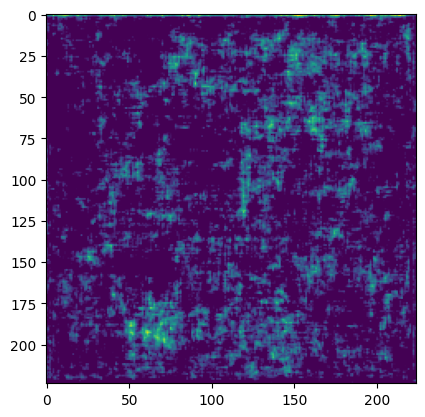

In [157]:
plt.imshow(r[0].permute(1,2,0).detach().numpy())
plt.show()

In [12]:
class Encoder2(nn.Module):
    def __init__(self):
        super(Encoder2, self).__init__()       
        self.original_model = models.densenet169( weights=True )

    def forward(self, x):
        features = [x]
        for k, v in self.original_model.features._modules.items(): features.append( v(features[-1]) )
        return features

In [158]:
model.load_state_dict(torch.load(".\\model\\resnet50\\2024-03-21_16-16_0.21153272916972637_2.pth"))

<All keys matched successfully>

In [13]:
r.shape

torch.Size([1, 1, 112, 112])

In [129]:
class NYUData(Dataset):
        def __init__(self, chunk):
            #ds = torch.tensor(load_dataset("sayakpaul/nyu_depth_v2", cache_dir = "./data"))
            self.chunk = chunk
            self.data = ds
            
        def __getitem__(self, index):
            flip = random.randint(0,1)
            rot = random.randint(-45,45)
            
            self.rgb_trans = A.Compose([
                A.Resize(width = 224, height = 224),
                A.Normalize(
                       mean = [0.0, 0.0, 0.0],
                        std = [1.0, 1.0, 1.0],
                        max_pixel_value=255
                    ),
                A.HorizontalFlip(p=flip),
               
                A.RandomBrightnessContrast(p = 1),
                
                ToTensorV2()
            ])
            self.dep_trans = A.Compose([
                A.Resize(width = 224, height = 224),
                A.HorizontalFlip(p=flip),
                
                ToTensorV2()
            ])
            image = self.data[self.chunk][index]['image']
            image = TF.rotate(img = image, interpolation = transforms.InterpolationMode.BILINEAR , angle = rot, expand= False)
            image = TF.center_crop(img = image, output_size = [224])
            image = np.array(image)
            image = self.rgb_trans(image = image)["image"]
            
            depth = self.data[self.chunk][index]['depth_map']
            depth = TF.rotate(img = depth, interpolation = transforms.InterpolationMode.BILINEAR, angle = rot, expand= False)
            depth = TF.center_crop(img = depth, output_size = [224])
            depth = np.array(depth)
            
            depth = self.dep_trans(image = depth)["image"]
            return  image , depth 
        def __len__(self):
            return len(self.data[self.chunk])

In [15]:

dataset = NYUData('train')
train_loader = DataLoader(dataset=dataset, shuffle = True, batch_size=8, pin_memory=True)


In [131]:
train_size = 20000
dataset = NYUData('train')
train_set, val_set = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

In [132]:
train_loader = DataLoader(dataset=train_set, shuffle = True, batch_size=8, pin_memory=True)

In [29]:
dataset = NYUData('validation')
data_loader = DataLoader(dataset=dataset, batch_size=64)

In [59]:
model.to(DEVICE)
print("i have no idea what I am doing")

i have no idea what I am doing


In [20]:
def delta_accuracy(predicted_depth, true_depth, threshold=1.25 ):
    assert predicted_depth.shape == true_depth.shape
    max_ratio = torch.max(predicted_depth/true_depth, true_depth/predicted_depth)
    delta_accuracy = torch.mean((max_ratio<threshold).float()) * 100
    return delta_accuracy.item()
    

In [21]:
def average_relative_error(y_true, y_pred):
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    

    absolute_differences = torch.abs(y_true - y_pred)
    
    # Avoid division by zero by adding a small constant; adjust as necessary
    epsilon = 1e-8
    relative_errors = absolute_differences / (y_true + epsilon)
    
    # Calculate the mean of relative errors
    average_error = torch.mean(relative_errors)
    
    return average_error

def rmse(y_true, y_pred):
    mse = F.mse_loss(y_pred, y_true, reduction='mean')
    rmse = torch.sqrt(mse)
    return rmse
def average_log10_error(y_true, y_pred):
   
    # Ensure that y_true and y_pred are torch tensors
    y_true = torch.as_tensor(y_true, dtype=torch.float32)
    y_pred = torch.as_tensor(y_pred, dtype=torch.float32)
    
    # Compute the log10 of the absolute ratio of predicted to actual values
    # Adding a small constant to the denominator to prevent division by zero
    epsilon = 1e-8
    log10_errors = torch.log10(torch.abs(y_pred / (y_true + epsilon)))
    
    # Calculate the mean of the absolute log10 errors
    average_log10_error = torch.mean(torch.abs(log10_errors))
    
    return average_log10_error

In [18]:
loop = tqdm(data_loader)

  0%|                                                                                           | 0/11 [00:00<?, ?it/s]

In [45]:
len(dataset)

47584

In [20]:
for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device = DEVICE)
    targets = targets.to(device = DEVICE)

    #forward
    with torch.cuda.amp.autocast():
        predictions = model(data)
        print(predictions.shape)
        print(delta_accuracy(predictions, targets, threshold=1.25 ))
        print(delta_accuracy(predictions, targets, threshold=1.5625 ))
        print(delta_accuracy(predictions, targets, threshold=1.95 ))
        print(average_relative_error(targets, predictions))
        print(rmse(targets, predictions))
        print(average_log10_error(targets, predictions))
        break

torch.Size([64, 1, 112, 112])
49.154972076416016
77.27275085449219
91.1612319946289


  0%|                                                                                           | 0/11 [00:30<?, ?it/s]

tensor(0.3139, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(1.3635, device='cuda:0', grad_fn=<SqrtBackward0>)
tensor(0.1265, device='cuda:0', grad_fn=<MeanBackward0>)


In [149]:

def show_depths(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8)[0])
    
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images.detach()[:nmax], nrow=8).permute(1, 2, 0), vmax = 1)

def show_batch(dl, nmax=64):
    for images, depth in dl:
        show_images(images, nmax)
        show_depths(depth, nmax)
        break

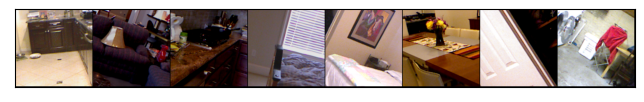

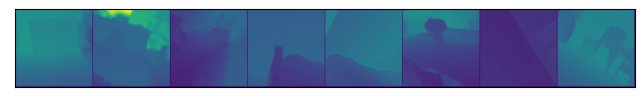

In [150]:
show_batch(train_loader,8)


In [17]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

In [32]:
i = 0
for param in model.parameters():
    i= i + 1
    if(i == 25):
        break
    param.requires_grad = False
    #print(param.requires_grad )
print(i)    

25


In [41]:

for param in model.parameters():
    param.requires_grad =True

In [135]:


class SSIM(torch.nn.Module):
    def __init__(self):
        super(SSIM, self).__init__()
        

    def forward(self, x, y):
        Mx = torch.mean(x)
        My = torch.mean(y)
        xy = x * y
        #Vx = torch.mean((x - Mx) ** 2)
        Vx = torch.mean((x) ** 2) - Mx**2
        #Vy = torch.mean((y - My) ** 2)
        Vy = torch.mean((y) ** 2) - My**2
        Vxy = torch.mean(xy) - Mx * My
        Vcxy = torch.mean((x - Mx)*(y - My))
        c1 = (0.01)**2 
        c2 = (0.03)**2
        
        l = (2 * Mx * My + c1)/(Mx**2 + My**2 + c1)
        c = (2 * torch.sqrt(Vx * Vy) + c2)/(Vx + Vy + c2)
        s = (Vxy + c2/2) / (torch.sqrt(Vx * Vy) + c2/2)

        #ssim = (2*Mx*My + c1) * (2*Vxy + c2)/(Mx**2 + My**2 + c1)*(Vx**2 + Vy**2 + c2) 
        ssim = l * c * s
        lssim = torch.clamp((1 - ssim)*0.5,0,1)
        return ssim

In [136]:
class Loss_Function(nn.Module):
    def __init__(self):
        super().__init__()
        self.L1 = nn.L1Loss()
        self.ssim = SSIM()
    def forward(self,yhat,y):
        loss = self.L1(yhat, y)
        loss1 = torch.abs(self.ssim(yhat, y)) 
        return loss * 0.1 + loss1

In [167]:
#model =UNET().to(DEVICE)
#load from checkpoint
#model.load_state_dict(torch.load("D:\\DLStudy\\nyuDepth\\model\\2023-09-03_14-57_3_checkpoint.pth"))

model.to(DEVICE)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()
    

In [160]:
#loss_fn = nn.MSELoss()
#loss_fn = nn.L1Loss()
loss_fn = Loss_Function()

In [161]:
def Average(lst):
    return sum(lst) / len(lst)

In [162]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)
    history = 0
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device = DEVICE)
        targets = targets.to(device = DEVICE)
        
        #forward
        with torch.cuda.amp.autocast(enabled=False):
            predictions = model(data)
            #loss = loss_fn(predictions['out'], targets)
            loss = loss_fn(predictions, targets)
            history= history + loss.item()
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        loop.set_postfix(loss = loss)
    history = history/len(loader)
    return history    

In [23]:
def train(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader, position=0, leave=True)
    history = 0
  
    for batch_idx, (data, targets) in enumerate(loop):



        predictions = model(data)
       
        loss = loss_fn(predictions, targets)
        history= history + loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss = loss)
        loop.update()
    history = history/len(loader)
    return history 

In [163]:
def save_result(epoch):
    i = 0
    for batch in train_loader:
        i = i+ 1
        if(i==100): 
            image, depth = batch
            r = model(image.cuda())
            f, axarr = plt.subplots(2,4)
            for ax in axarr.flatten():
                ax.set_xticks([])
                ax.set_yticks([])
            for i in range(4):
                axarr[0][i].imshow(depth[i].detach().permute(1,2,0))
                axarr[1][i].imshow(r[i][0].cpu().detach().numpy())
            PATH = os.path.join(os.getcwd(), "result", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" +str(epoch) + ".jpg")
            plt.savefig(PATH)
            break


In [ ]:
result = []
for epoch in range(3, NUM_EPOCHS):
    l = train(train_loader, model, optimizer, loss_fn, scaler)
    result.append(l)

    PATH = os.path.join(os.getcwd(), "model", "resnet50", datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_" + str(l) + "_" +str(epoch) + ".pth")
    torch.save(model.state_dict(), PATH)
    save_result(epoch)

 28%|████▋            | 693/2500 [08:08<20:16,  1.49it/s, loss=tensor(0.2813, device='cuda:0', grad_fn=<AddBackward0>)]

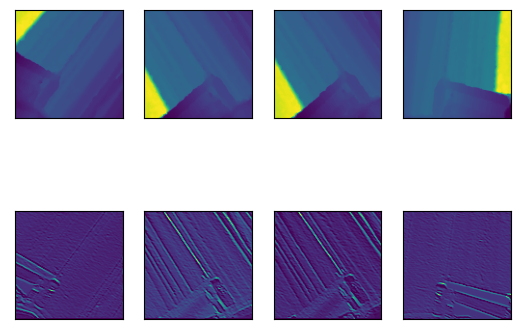

In [49]:
save_result(0)